In [1]:
import os
import numpy as np
import nibabel as nib
import time
import matplotlib.pyplot as plt

# Start time
start_time = time.time()

# Utility Functions

In [2]:
def segment_brain_image(W, original_image, voxel_indices, cluster_means):
    """
    Segments a 3D brain image based on voxel cluster probabilities.
    
    Parameters:
    - W: 2D array where each row represents voxel probabilities for each cluster (shape: [num_voxels, num_clusters]).
    - original_image: 3D array representing the original brain image (shape: [x, y, z]).
    - voxel_indices: Tuple of indices representing the location of brain tissue voxels.
    - cluster_means: 1D array of mean intensities for each cluster.
    
    Returns:
    - segmented_image: 3D array with segmented classes assigned (1 for CSF, 2 for GM, 3 for WM).
    """
    # Assign each voxel to the cluster with the highest probability
    voxel_cluster_assignments = np.argmax(W, axis=1)
    
    # Create a new 3D segmented image initialized to zero (background)
    segmented_image = np.zeros_like(original_image)
    
    # Map the voxel assignments back to the 3D segmented image using voxel indices
    segmented_image[voxel_indices] = voxel_cluster_assignments + 1  # +1 to label clusters as 1, 2, 3
    
    # Sort clusters based on mean intensity values
    sorted_cluster_indices = np.argsort(np.mean(cluster_means, axis=1)) + 1
    
    # Assign clusters to classes: 1 - CSF, 2 - GM, 3 - WM
    csf_voxels = np.where(segmented_image == sorted_cluster_indices[0])
    gm_voxels = np.where(segmented_image == sorted_cluster_indices[1])
    wm_voxels = np.where(segmented_image == sorted_cluster_indices[2])
    
    segmented_image[csf_voxels] = 1
    segmented_image[gm_voxels] = 2
    segmented_image[wm_voxels] = 3
    
    return segmented_image

In [23]:
def normalize_probabilities(probabilities):
    """
    Normalizes the probabilities across classes (tissues) for each voxel to ensure they sum to 1.
    
    Parameters:
        probabilities (np.ndarray): 4D array of shape (X, Y, Z, C),
                                     where C is the number of classes (tissues).
    
    Returns:
        np.ndarray: Normalized probability map of the same shape as input.
    """
    # Compute the sum of probabilities across all classes for each voxel
    sum_probabilities = np.sum(probabilities, axis=-1, keepdims=True)

    # Avoid division by zero (if sum is zero, keep probabilities as zero)
    sum_probabilities[sum_probabilities == 0] = 1.0

    # Normalize probabilities by dividing each class probability by the sum
    normalized_probabilities = probabilities / sum_probabilities

    return normalized_probabilities

In [3]:
%cd /Users/sumeetdash/MAIA/Semester_3/CODES/MISA/Final_Project/MISA-MultiAtlas-Segmentation

/Users/sumeetdash/MAIA/Semester_3/CODES/MISA/Final_Project/MISA-MultiAtlas-Segmentation


/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
from src.utils.helpers import load_nifti, save_nifti, calculate_dice_score
from src.utils.sliding_window import extract_windows, merge_windows
from src.segmentation.fusion_methods import majority_vote_with_probabilities, staple_fusion, probability_fusion
from src.evaluation.metrics import compute_dice_coefficient
from src.segmentation.label_fusion_pipeline import LabelFusionPipeline

In [5]:
atlas_path = './Data/transformed_labels/IBSR_11'
fixed_image_path = './Data/SPM/Output/Validation_Set/IBSR_11/processed_mIBSR_11.nii'
ground_truth_path = './Data/SPM/Output/Validation_Set/IBSR_11/processed_IBSR_11_seg.nii'

In [6]:
fixed_image, fixed_affine = load_nifti(fixed_image_path)
ground_truth, _ = load_nifti(ground_truth_path)


In [7]:
pipeline = LabelFusionPipeline(
    fixed_image=fixed_image,
    transformed_labels_dir = atlas_path
)
fusion_methods = {
    "Majority Voting": majority_vote_with_probabilities
}

In [8]:
results = {}
for method_name, fusion_method in fusion_methods.items():
    print(f"Running {method_name}...")
    pipeline.load_transformed_labels()
    pipeline.apply_fusion(fusion_method, prob=True)
    fused_result = pipeline.fused_label
    probabilities = pipeline.fused_probabilities

    # Evaluate and store metrics
    dice_score = calculate_dice_score(np.squeeze(ground_truth), fused_result)
    results[method_name] = {"Dice": dice_score}

Running Majority Voting...


Loaded 10 transformed labels.
Applied fusion strategy.


In [9]:
# Print evaluation metrics
print("\nEvaluation Metrics:")
for method_name, metrics in results.items():
    print(f"{method_name}: Dice = {sum(metrics['Dice'].values()) / len(metrics['Dice']):.4f}")
    print(f"{method_name}: Dice = {metrics['Dice']}")


Evaluation Metrics:
Majority Voting: Dice = 0.8405
Majority Voting: Dice = {1.0: 0.8309070548712206, 2.0: 0.8564463408164091, 3.0: 0.8340764302212293}


In [24]:
tissue_probabilities = probabilities[:, :, :, 1:]

In [25]:
tissue_probabilities = normalize_probabilities(tissue_probabilities)

In [28]:
%cd ./ExpectationMaximization/

/Users/sumeetdash/MAIA/Semester_3/CODES/MISA/Final_Project/MISA-MultiAtlas-Segmentation/ExpectationMaximization


/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [66]:
from em_algo import ExpectationMaximization

In [67]:
background_mask = fixed_image > 0
csf_probabilities = tissue_probabilities[background_mask, 0]
gm_probabilities = tissue_probabilities[background_mask, 1]
wm_probabilities = tissue_probabilities[background_mask, 2]

In [68]:
X_test = fixed_image[background_mask]
X_test = np.expand_dims(X_test, axis = 1)

In [69]:
W = np.stack([csf_probabilities, gm_probabilities, wm_probabilities], axis=1)

Iteration:  0  --- Log Likelihood:  8.427869665241209  --- Time (s):  0.08029484748840332


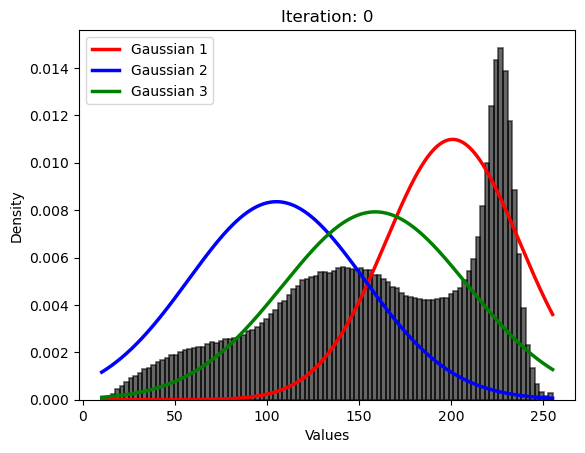

Iteration:  1  --- Log Likelihood:  8.440999028716272  --- Time (s):  0.07613897323608398
Iteration:  2  --- Log Likelihood:  8.455781975125849  --- Time (s):  0.07489895820617676
Iteration:  3  --- Log Likelihood:  8.474790353633113  --- Time (s):  0.07151317596435547
Iteration:  4  --- Log Likelihood:  8.498088404861779  --- Time (s):  0.06824970245361328
Iteration:  5  --- Log Likelihood:  8.52485872359471  --- Time (s):  0.06966400146484375
Iteration:  6  --- Log Likelihood:  8.553243479569227  --- Time (s):  0.07242393493652344
Iteration:  7  --- Log Likelihood:  8.58047249793957  --- Time (s):  0.07277989387512207
Iteration:  8  --- Log Likelihood:  8.604069689222957  --- Time (s):  0.07202625274658203
Iteration:  9  --- Log Likelihood:  8.622935891778813  --- Time (s):  0.07140898704528809
Iteration:  10  --- Log Likelihood:  8.637247269251096  --- Time (s):  0.07079100608825684
Iteration:  11  --- Log Likelihood:  8.647776574097481  --- Time (s):  0.07111072540283203
Iteration:

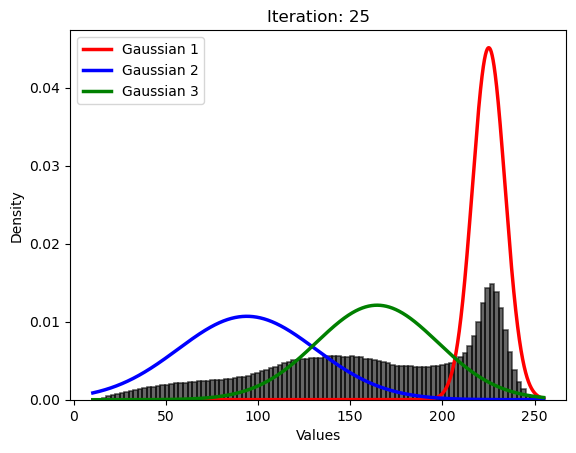

Iteration:  26  --- Log Likelihood:  8.674907859366336  --- Time (s):  0.07577395439147949
Iteration:  27  --- Log Likelihood:  8.675034264272412  --- Time (s):  0.07366299629211426
Iteration:  28  --- Log Likelihood:  8.675141123992772  --- Time (s):  0.07415103912353516
Iteration:  29  --- Log Likelihood:  8.675231753735346  --- Time (s):  0.072052001953125
Iteration:  30  --- Log Likelihood:  8.675308802447498  --- Time (s):  0.07027220726013184
Iteration:  31  --- Log Likelihood:  8.675374430015985  --- Time (s):  0.06592798233032227
Iteration:  32  --- Log Likelihood:  8.675430419141122  --- Time (s):  0.06658315658569336
Iteration:  33  --- Log Likelihood:  8.675478251798342  --- Time (s):  0.06660079956054688
Iteration:  34  --- Log Likelihood:  8.67551916555885  --- Time (s):  0.06659412384033203
Iteration:  35  --- Log Likelihood:  8.675554197356966  --- Time (s):  0.0682978630065918
Iteration:  36  --- Log Likelihood:  8.675584218552702  --- Time (s):  0.07418608665466309
Ite

In [70]:
em = ExpectationMaximization(X_test, k=3, max_iter=200, type='kmeans', plot_step=25, save_path=None, show_plot= True, stop_criterion=1e-5)
alphas, mus, covars, W_out = em.fit()

In [74]:
segmented_image = segment_brain_image(W_out, fixed_image, background_mask, mus)

In [75]:
dice_score = calculate_dice_score(np.squeeze(ground_truth), segmented_image)
results['EM'] = {"Dice": dice_score}

In [76]:
# Print evaluation metrics
print("\nEvaluation Metrics:")
for method_name, metrics in results.items():
    print(f"{method_name}: Dice = {sum(metrics['Dice'].values()) / len(metrics['Dice']):.4f}")
    print(f"{method_name}: Dice = {metrics['Dice']}")


Evaluation Metrics:
Majority Voting: Dice = 0.8405
Majority Voting: Dice = {1.0: 0.8309070548712206, 2.0: 0.8564463408164091, 3.0: 0.8340764302212293}
EM: Dice = 0.5543
EM: Dice = {1.0: 0.07790435962261824, 2.0: 0.7205944617610451, 3.0: 0.864313101553575}
